# Laboratorium

### Konfiguracja

In [4]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

### Przykłady użycia

##### Proste rysowanie

Rysowanie prostego rysunku złożonego ze statycznych punktów i odcinków jest stosunkowo proste. Należy utworzyć zmienną z obiektem `Plot`, który przyjmuje w konstruktorze listę obiektów `PointsCollection` jako parametr `points` oraz listę `LinesCollection` jako parametr `lines`. Następnie należy wywołać jego metodę `draw()`.

<IPython.core.display.Javascript object>


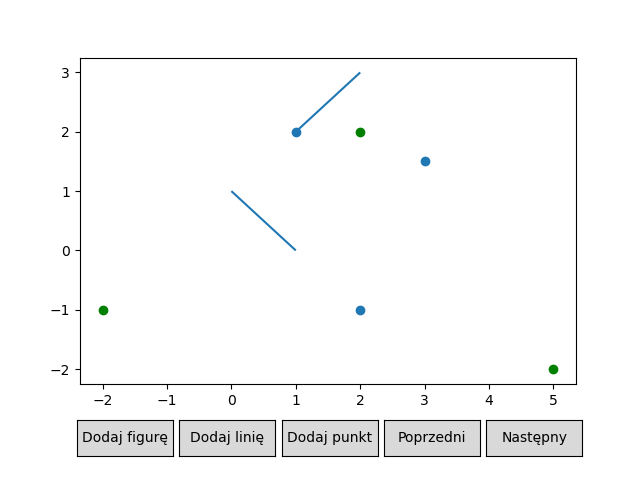

In [5]:
%matplotlib notebook

plot = Plot(points=[PointsCollection([(1, 2), (3, 1.5), (2, -1)]),
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green')],
            lines=[LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])])
plot.draw()

##### Rysunek dynamiczny

To narzędzie pozwala na wizualizację "rysunków dynamicznych", a więc takich, które składają się z wielu różnych obrazów. Może to być przydatne np. podczas wizualizacji kolejnych kroków danego algorytmu. Poszczególne klatki określane są jako obiekty `Scene`, które przyjmują listę `PointsCollection` oraz listę `LinesCollection` w swoim konstruktorze. Obiekt `Plot` przyjmuje w parametrze konstruktora `scenes` właśnie listę takich scen.

Na rysunku przyciski `Następny` i `Poprzedni` służą do nawigacji pomiędzy nimi.

<IPython.core.display.Javascript object>


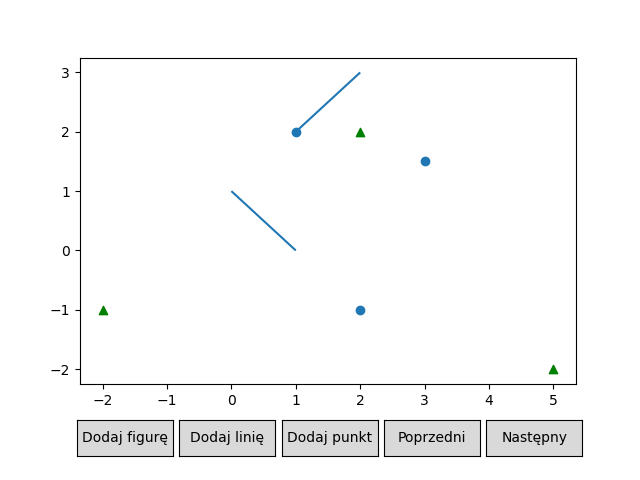

In [6]:
%matplotlib notebook

scenes=[Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)]), 
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)], color='red'), 
               PointsCollection([(5, -2), (2, 2), (-2, 1)], color='black')], 
              [LinesCollection([[(-1,2),(-2,3)], [(0,-1),(-1,0)]])])]

plot=Plot(scenes = scenes)
plot.draw() 


###### Zapis i odczyt z pliku

Klasa Plot posiada metodę `toJson()`, która zwraca string zawierający listę scen w formacie JSON. Taki string można normalnie zapisać do pliku stosując normalne sposoby dostępne w Pythonie. Wczytanie listy scen z pliku dokonuje się poprzez podanie parametru `json` w kostruktorze `Plot`.

<IPython.core.display.Javascript object>


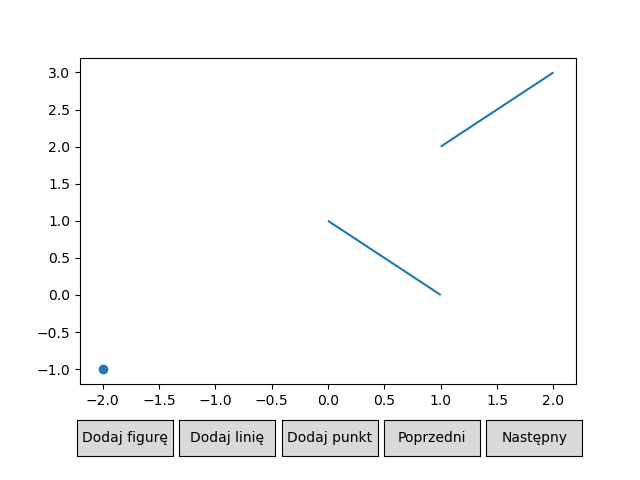

In [7]:
scenes=[Scene([PointsCollection([(-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5)], color='red'), 
               PointsCollection([(5, -2)], color='black')])]
plot = Plot(scenes)

with open('somefile.json', 'w') as file:
    file.write(plot.toJson())
    
#somefile.json: [{"points": [[[-2, -1]]], "lines": [[[[1, 2], [2, 3]], [[0, 1], [1, 0]]]]}, {"points": [[[1.0, 2.0], [3.0, 1.5]], [[5, -2]]], "lines": []}]
    
with open('somefile.json', 'r') as file:
    json = file.read()
    
plot2 = Plot(json=json)
plot2.draw()

##### Operowanie na dodanych punktach

Możemy bardzo łatwo rysować nowe punkty i linie. Aby je później wykorzystać sugerowanym sposobem jest utworzenie nowej komórki, w której utworzymy nowy `Plot` i skorzystamy z metod `get_added_points()` i `get_added_points()` lub `get_added_elements()` (zwraca scenę) z pierwszego `Plot`u.

<IPython.core.display.Javascript object>


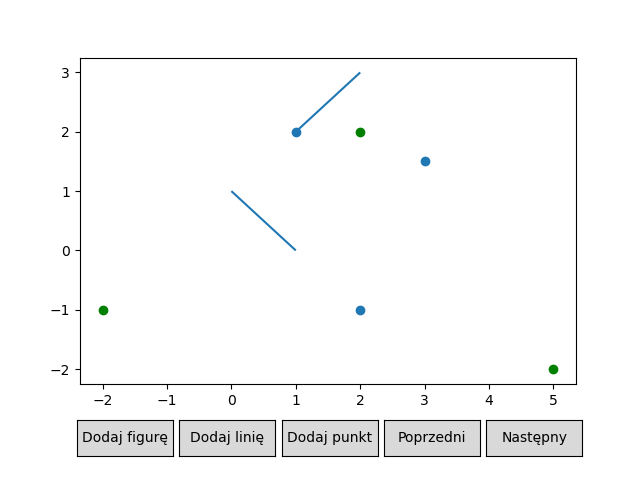

In [8]:
#Dodaj tu punkty, figury i/lub odcinki!
plot1 = Plot()
plot1.draw()

<IPython.core.display.Javascript object>


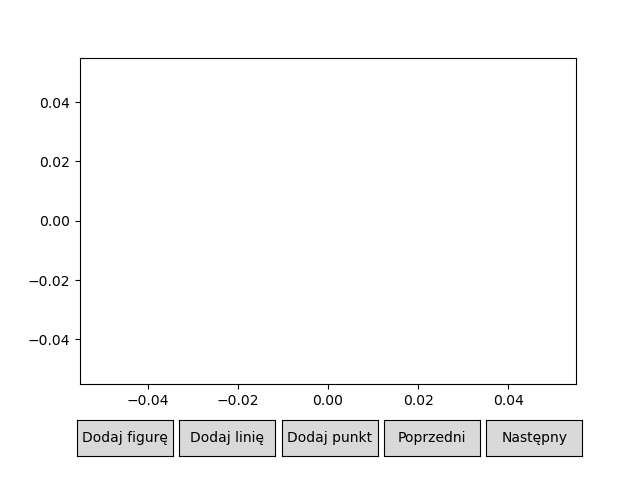

In [9]:
plot2 = Plot([plot1.get_added_elements()])
plot2.draw()

# Rozwiązanie

In [13]:
import random
import math
from random import randint
import numpy as np

# random.random() to generate a random floating-point number between 0 to 1
# random.uniform() to get a random float number within a range

<IPython.core.display.Javascript object>


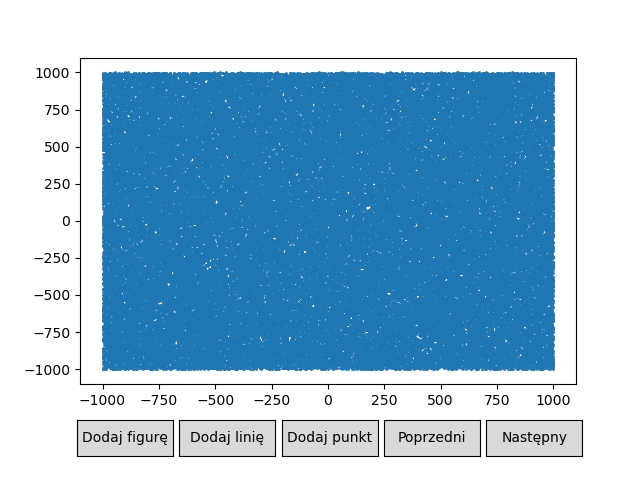

In [14]:
# 10^5 losowych punktów o współrzędnych z przedziału [-1000, 1000]

%matplotlib notebook
from random import randint
set_a = [(random.uniform(-1000,1000),random.uniform(-1000,1000)) for _ in range(100000)]

plot = Plot(points = [PointsCollection(set_a, s=1)])
plot.draw()

<IPython.core.display.Javascript object>


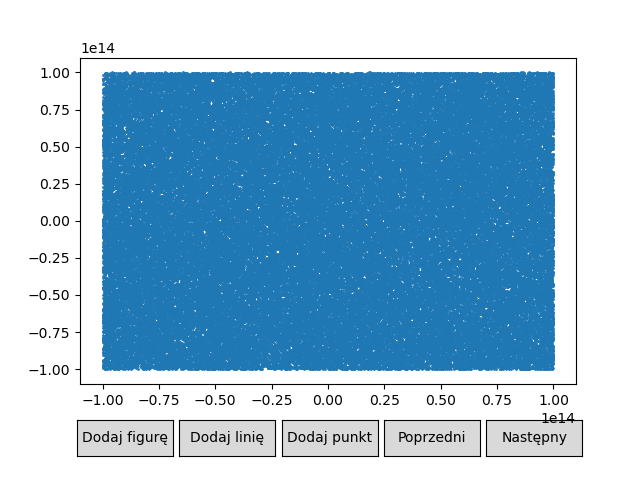

In [15]:
# 10^5 losowych punktów o współrzędnych z przedziału [-10^14, 10^14],

%matplotlib notebook

set_b = [(random.uniform(-10**14,10**14),random.uniform(-10**14,10**14)) for _ in range(100000)]
plot = Plot(points = [PointsCollection(set_b, s=1)])
plot.draw()

<IPython.core.display.Javascript object>


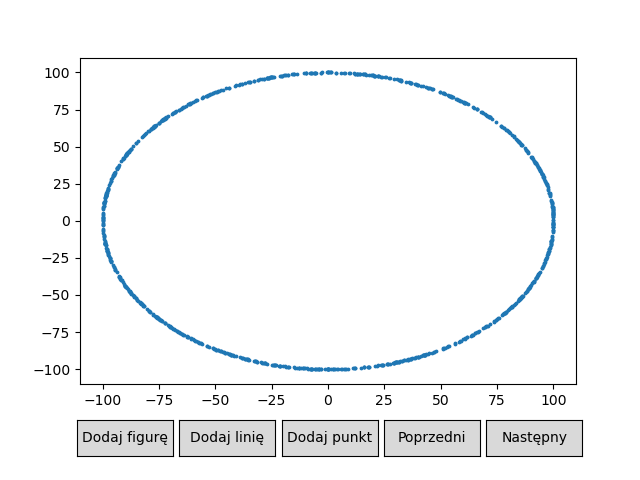

In [16]:
# 1000 losowych punktów leżących na okręgu o środku (0,0) i promieniu R=100

# parametryzacja okręgu
# x = rcos(t)
# y = rsin(t)
# gdzie: 0 <= t <= 2*pi


%matplotlib notebook

set_c = [None]*1000

for i in range(1000):
    t = random.uniform(0,2*math.pi)
    set_c[i] = (100*math.cos(t),100*math.sin(t))
    
plot = Plot(points = [PointsCollection(set_c, s=3)])
plot.draw()

<IPython.core.display.Javascript object>


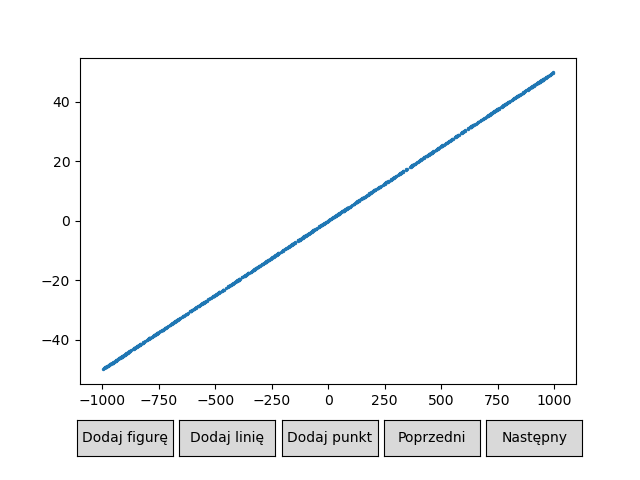

In [17]:
# 1000 losowych punktów o współrzędnych z przedziału [-1000, 1000] leżących na prostej
# wyznaczonej przez wektor (a, b), gdzie a = [-1.0, 0.0], b = [1.0, 0.1]

%matplotlib notebook

set_d = [None]*1000
a = [-1.0, 0.0]
b = [1.0, 0.1]

# równanie parametryczne prostej przechodzącej przez punkty (x1,y1) i (x2,y2)
# x = x1 + (x2 - x1)t  => t = (x - x1)/(x2 - x1)
# y = y1 + (y2 - y1)t

for i in range(1000):
    x  = random.uniform(-1000,1000)
    t = (x - a[0])/(b[0] - a[0])
    y = a[1] + (b[1] - a[1])*t
    set_d[i] = (x,y)
    
plot = Plot(points = [PointsCollection(set_d, s=2)])
plot.draw()

In [18]:
def det1(a,b,c):
    return a[0]*b[1] + b[0]*c[1] + a[1]*c[0] - c[0]*b[1] - b[0]*a[1] - a[0]*c[1]

In [19]:
def det2(a,b,c):
    return (a[0] - c[0])*(b[1] - c[1]) - (b[0] - c[0])*(a[1] - c[1])

In [20]:
# numpy.linalg.det() function

def det1_lib(a,b,c):
    a = np.array([[a[0],a[1],1],[b[0],b[1],1],[c[0],c[1],1]])
    return np.linalg.det(a)
    

In [21]:
# numpy.linalg.det() function

def det2_lib(a,b,c):
    a = np.array([[a[0] - c[0], a[1] - c[1]],[b[0] - c[0], b[1] - c[1]]])
    return np.linalg.det(a)


In [22]:
def group(points, det_func, tolerance = 0, a = [-1.0, 0.0], b = [1.0, 0.1]):
    cw = []      # clockwise - na prawo
    ccw = []     # counterclockwise - na lewo
    coll = []    # collinear - wspólliniowe

    for point in points:
        if det_func(a, b, point) > tolerance:
            ccw.append(point)
        elif det_func(a, b, point) < -1*tolerance:
            cw.append(point)
        else:
            coll.append(point)
            
    return cw, ccw, coll
            
    

In [23]:
def group_plot(points, det_func, tolerance = 0, set_d = False):
    
    cw, ccw, coll = group(points, det_func, tolerance)
    
    if set_d is False:
        plot = Plot(points = [PointsCollection(cw,color = 'midnightblue', s=3),
                              PointsCollection(ccw,color = 'chocolate', s=3),
                              PointsCollection(coll,color = 'palegreen', s=12)])
    else:
        plot = Plot(points = [PointsCollection(cw,color = 'midnightblue', s=3),
                              PointsCollection(ccw,color = 'chocolate', s=3),
                              PointsCollection(coll,color = 'palegreen', s=3)])
        
    print("right:", len(cw))
    print("left :", len(ccw))
    print("coll :", len(coll))
          
    plot.draw()

## Porównanie wyników (podział punktów) uzyskanych przy pomocy obu wyznaczników wyliczanych procedurami własnymi i bibliotecznymi

### set_a:

right: 50215
left : 49785
coll : 0


<IPython.core.display.Javascript object>


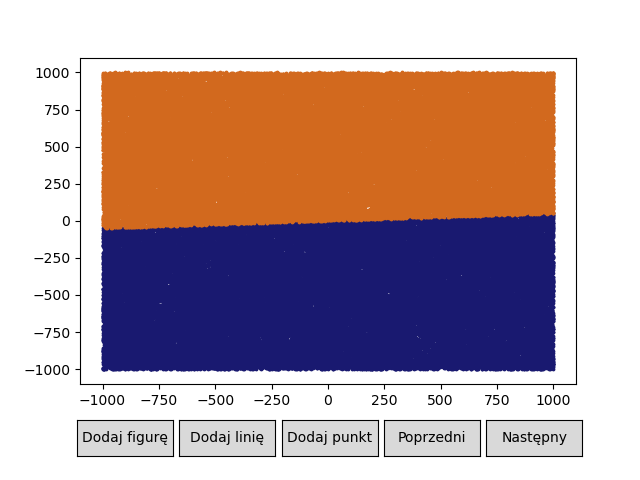

In [24]:
%matplotlib notebook

group_plot(set_a,det1)

right: 50215
left : 49785
coll : 0


<IPython.core.display.Javascript object>


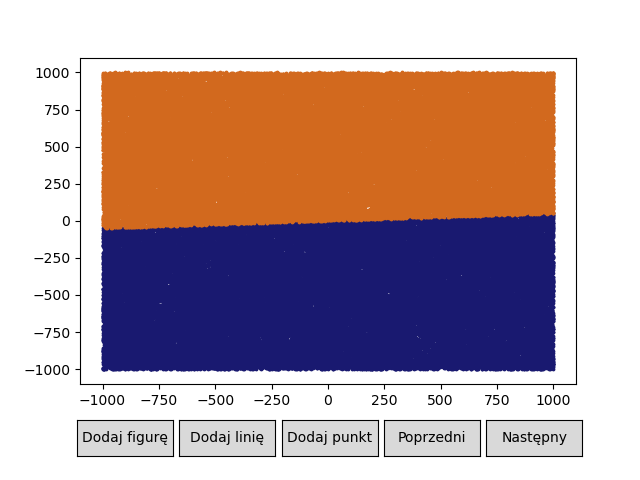

In [25]:
%matplotlib notebook

group_plot(set_a,det2)

right: 50215
left : 49785
coll : 0


<IPython.core.display.Javascript object>


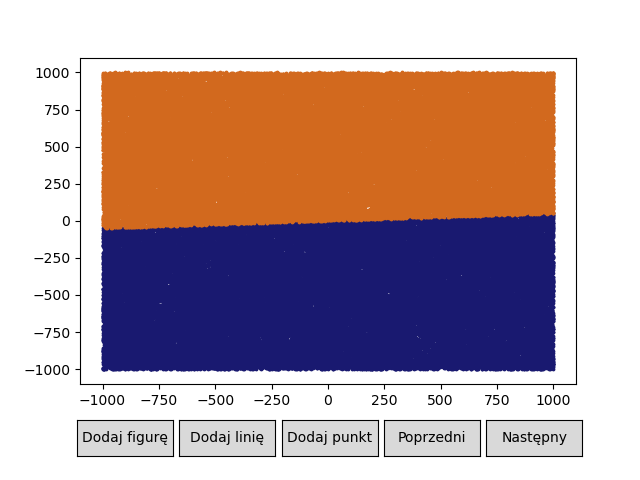

In [26]:
%matplotlib notebook

group_plot(set_a,det1_lib)

right: 50215
left : 49785
coll : 0


<IPython.core.display.Javascript object>


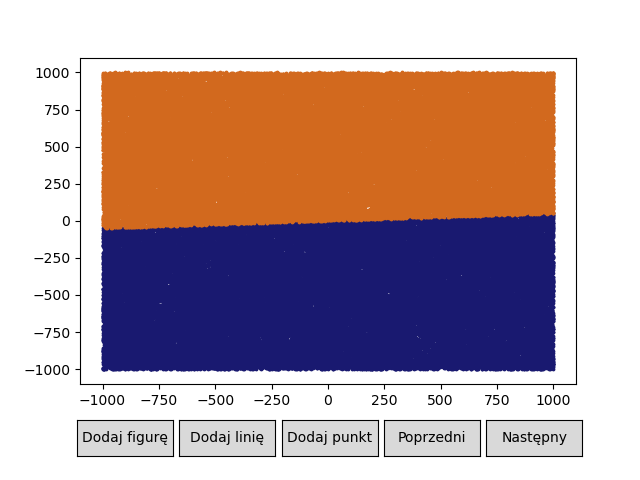

In [27]:
%matplotlib notebook

group_plot(set_a,det2_lib)

### set_b:

right: 50199
left : 49801
coll : 0


<IPython.core.display.Javascript object>


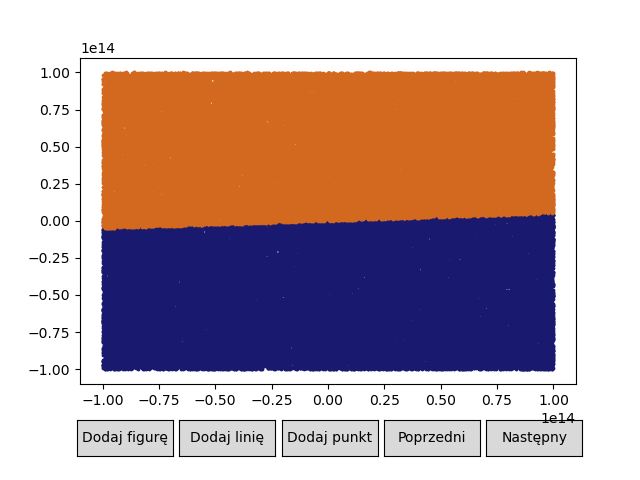

In [28]:
%matplotlib notebook
group_plot(set_b,det1)

right: 50196
left : 49797
coll : 7


<IPython.core.display.Javascript object>


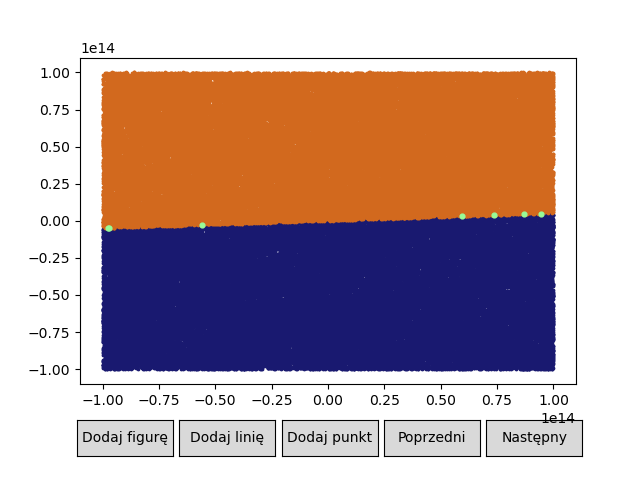

In [29]:
%matplotlib notebook
group_plot(set_b,det2)

right: 50199
left : 49801
coll : 0


<IPython.core.display.Javascript object>


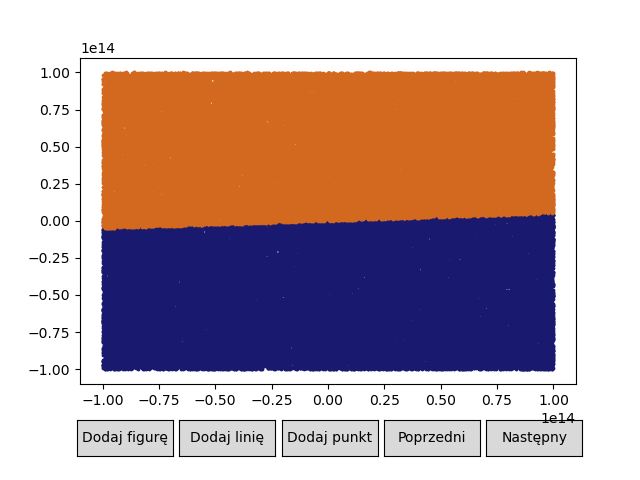

In [30]:
%matplotlib notebook
group_plot(set_b,det1_lib)

right: 50196
left : 49796
coll : 8


<IPython.core.display.Javascript object>


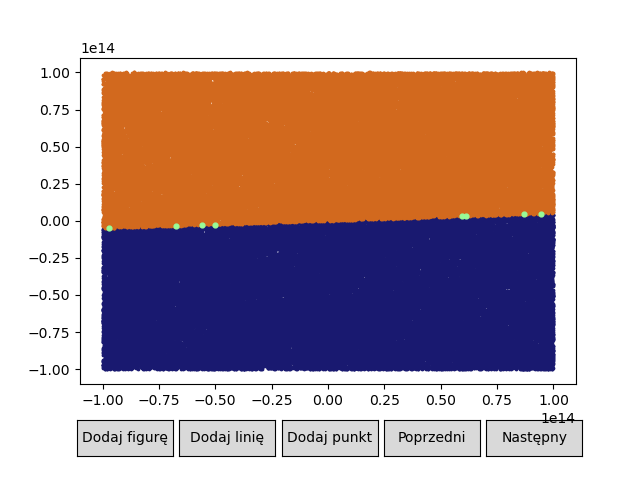

In [31]:
%matplotlib notebook
group_plot(set_b,det2_lib)

### set_c:

right: 522
left : 478
coll : 0


<IPython.core.display.Javascript object>


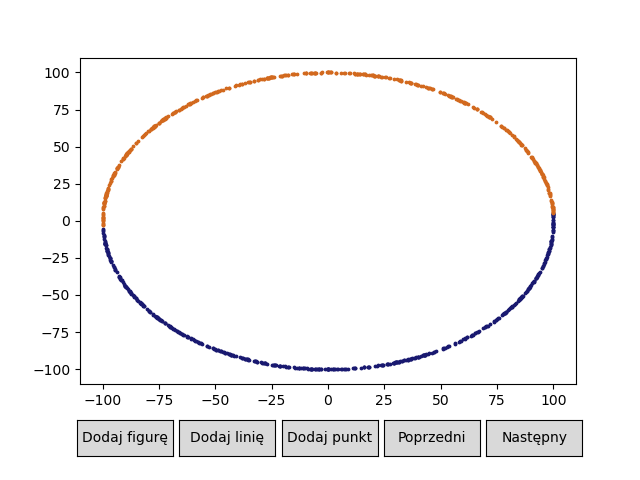

In [32]:
%matplotlib notebook
group_plot(set_c,det1)

right: 522
left : 478
coll : 0


<IPython.core.display.Javascript object>


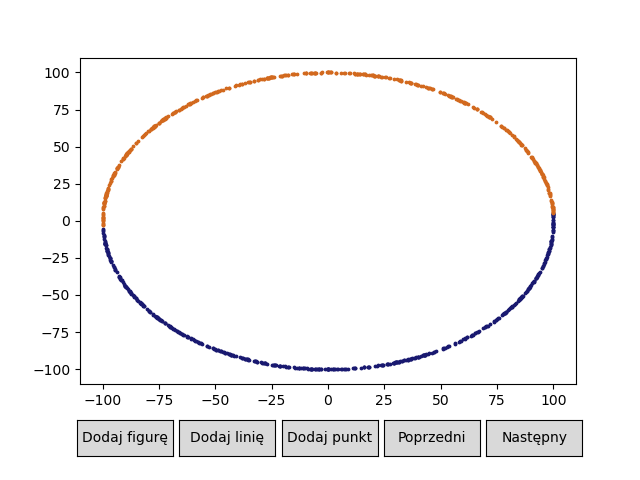

In [33]:
%matplotlib notebook
group_plot(set_c,det2)

right: 522
left : 478
coll : 0


<IPython.core.display.Javascript object>


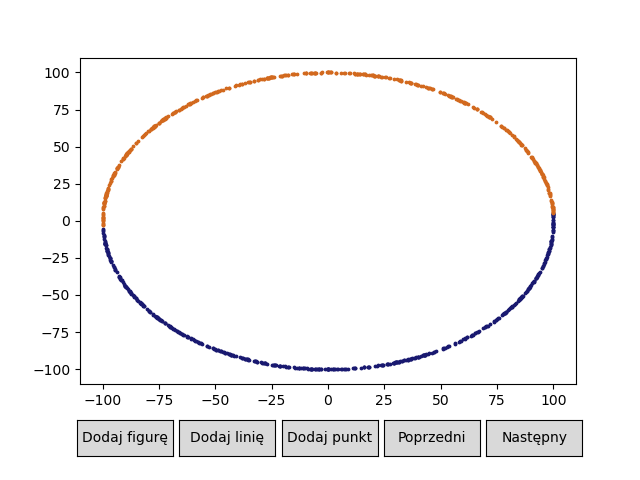

In [34]:
%matplotlib notebook
group_plot(set_c,det1_lib)

right: 522
left : 478
coll : 0


<IPython.core.display.Javascript object>


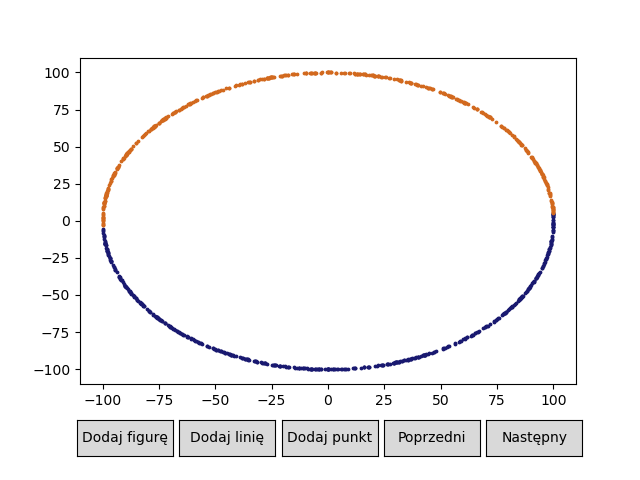

In [35]:
%matplotlib notebook
group_plot(set_c,det2_lib)

### set_d:

right: 366
left : 308
coll : 326


<IPython.core.display.Javascript object>


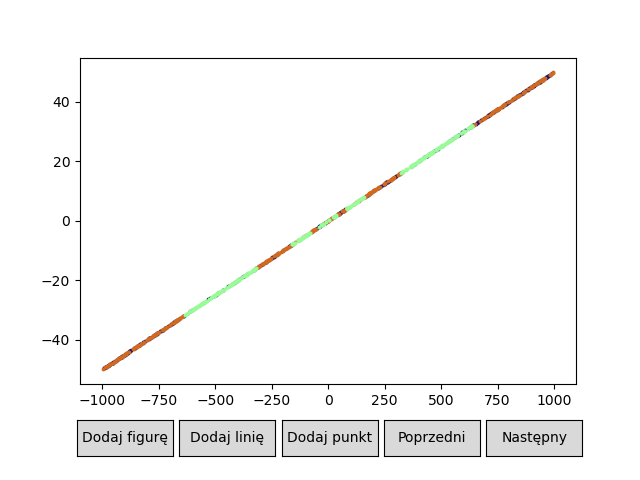

In [36]:
%matplotlib notebook
group_plot(set_d,det1, set_d = True)

right: 145
left : 137
coll : 718


<IPython.core.display.Javascript object>


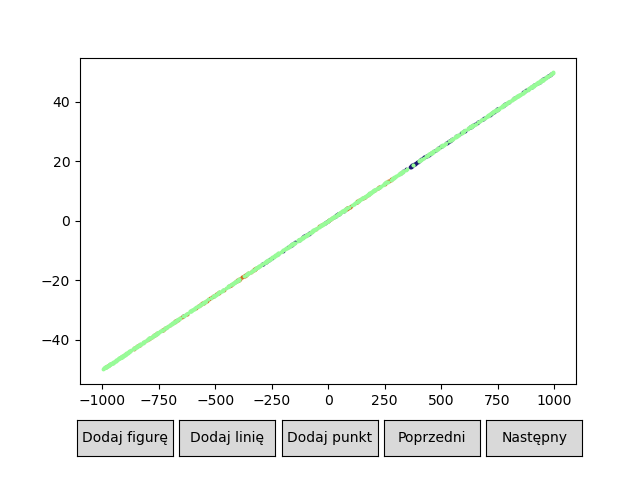

In [37]:
%matplotlib notebook
group_plot(set_d,det2, set_d = True)

right: 370
left : 399
coll : 231


<IPython.core.display.Javascript object>


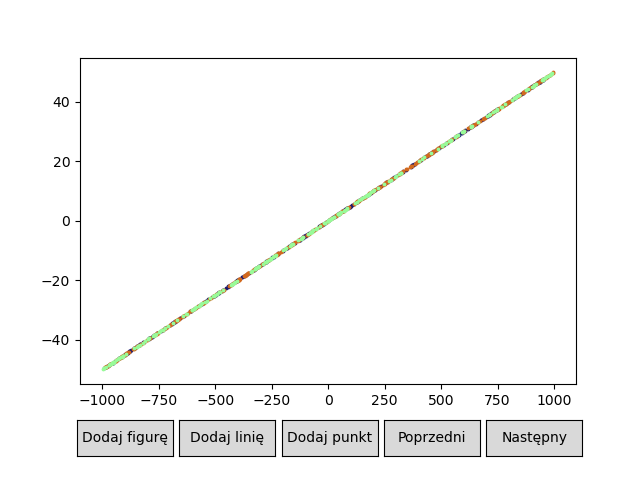

In [38]:
%matplotlib notebook
group_plot(set_d,det1_lib, set_d = True)

right: 156
left : 148
coll : 696


<IPython.core.display.Javascript object>


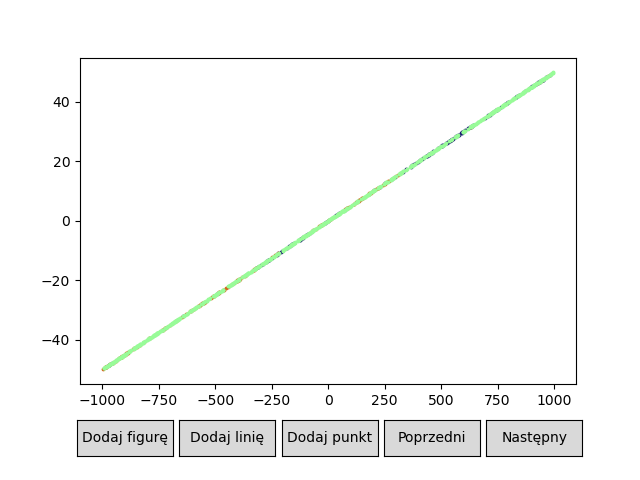

In [39]:
%matplotlib notebook
group_plot(set_d,det2_lib, set_d = True)

In [40]:
# ile punktów (i jakich) zostało inaczej zakwalifikowanych dla różnych sposobów liczenia wyznacznika

def compare(Set, det_func1, det_func2, tolerance = 0):

    cw_1, ccw_1, coll_1 = group(Set, det_func1, tolerance)
    
    arr1 = [None]*(len(Set))
    arr2 = [None]*(len(Set))
    
    idx = 0
    
    # przepisuję do tablicy
    
    # na lewo
    for point in cw_1:
        arr1[idx] = [point, 'right']
        idx+=1
    # na prawo
    for point in ccw_1:
        arr1[idx] = [point, 'left']
        idx+=1
    # współliniowe
    for point in coll_1:
        arr1[idx] = [point, 'coll']
        idx+=1
        
    arr1.sort()
        
    cw_2, ccw_2, coll_2 = group(Set, det_func2, tolerance)
    idx = 0
    for point in cw_2:
        arr2[idx] = [point, 'right']
        idx+=1
   
    for point in ccw_2:
        arr2[idx] = [point, 'left']
        idx+=1
    
    for point in coll_2:
        arr2[idx] = [point, 'coll']
        idx+=1
     
    arr2.sort()
    
    
    diff = []
    for i in range(len(Set)):
        if arr1[i][0] == arr2[i][0] and arr1[i][1] != arr2[i][1]:
            diff.append(arr1[i][0])
            
    return diff
            

In [41]:
def diff_plot(Set, det_func1, det_func2, tolerance = 0):
    
    diff = compare(Set, det_func1, det_func2, tolerance)
    plot = Plot(points = [PointsCollection(diff, color = "tomato", s = 10)])
    print("diff: ", len(diff))
    
    if len(diff) > 0:
        plot.draw()
    

### set_a:

In [42]:
%matplotlib notebook
diff_plot(set_a,det1,det1_lib)

diff:  0


In [43]:
%matplotlib notebook
diff_plot(set_a,det2,det2_lib)

diff:  0


### set_b:

In [44]:
%matplotlib notebook
diff_plot(set_b,det1,det1_lib)

diff:  0


diff:  5


<IPython.core.display.Javascript object>


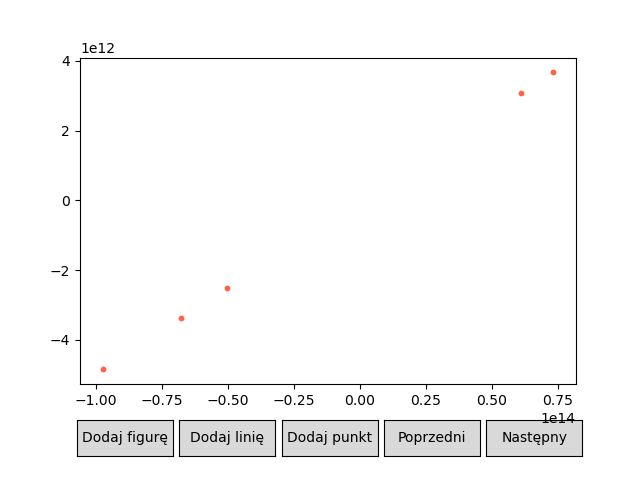

In [45]:
%matplotlib notebook
diff_plot(set_b,det2,det2_lib)

### set_c:

In [46]:
%matplotlib notebook
diff_plot(set_c,det1,det1_lib)

diff:  0


In [47]:
%matplotlib notebook
diff_plot(set_c,det2,det2_lib)

diff:  0


### set_d:

diff:  559


<IPython.core.display.Javascript object>


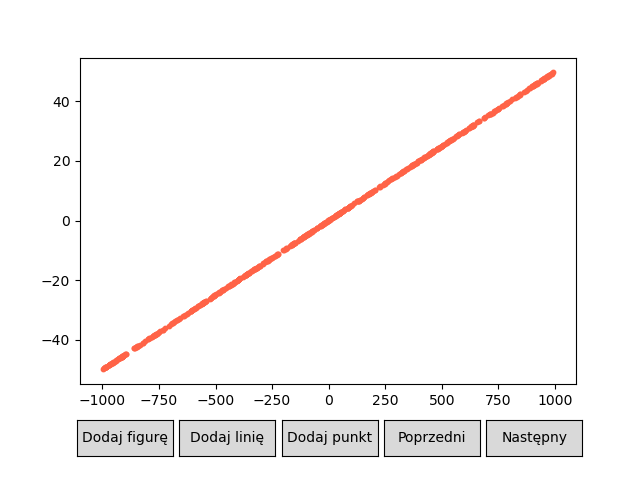

In [48]:
%matplotlib notebook
diff_plot(set_d,det1,det1_lib)

diff:  403


<IPython.core.display.Javascript object>


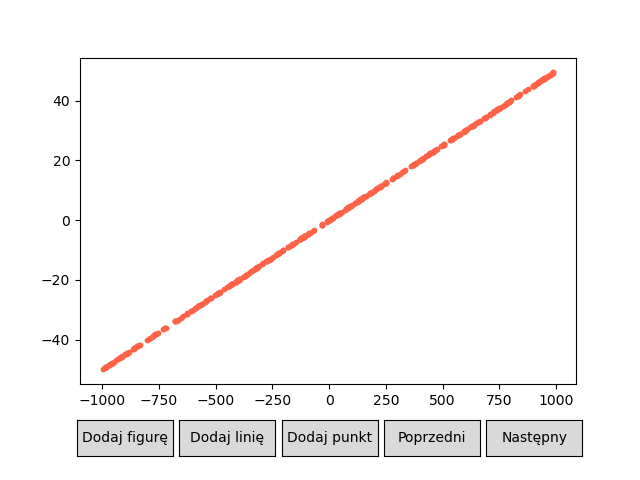

In [49]:
%matplotlib notebook
diff_plot(set_d,det2,det2_lib)

## Porównanie różnych tolerancji dla 0

### Kilka ciekawszych wykresów i obserwacji:

right: 366
left : 308
coll : 326


<IPython.core.display.Javascript object>


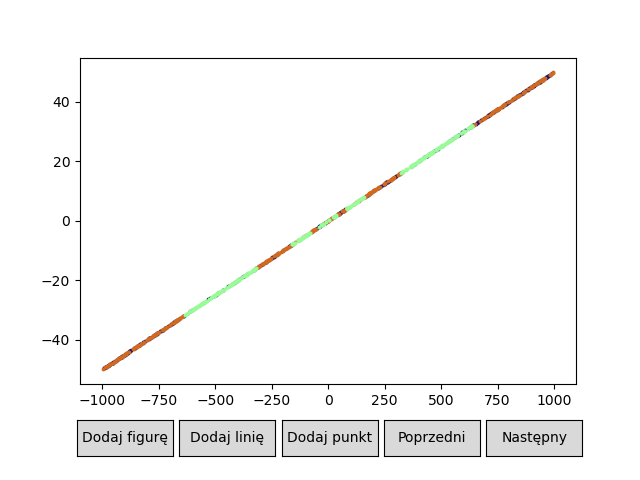

In [50]:
%matplotlib notebook
group_plot(set_d, det1, 10**-18, set_d = True)

diff:  559


<IPython.core.display.Javascript object>


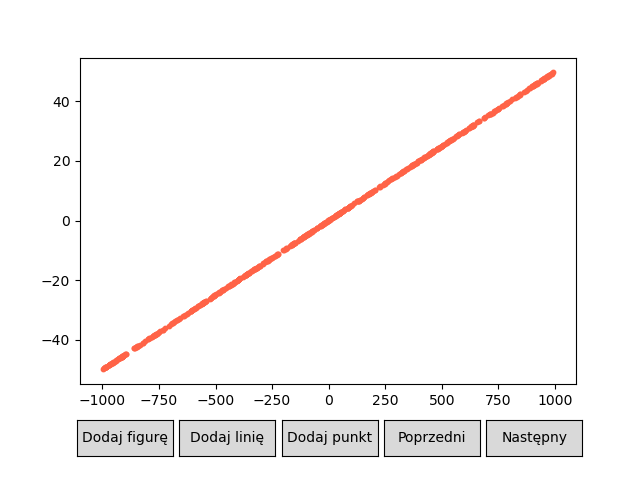

In [51]:
%matplotlib notebook
diff_plot(set_d,det1,det1_lib, 10**-18)

right: 0
left : 0
coll : 1000


<IPython.core.display.Javascript object>


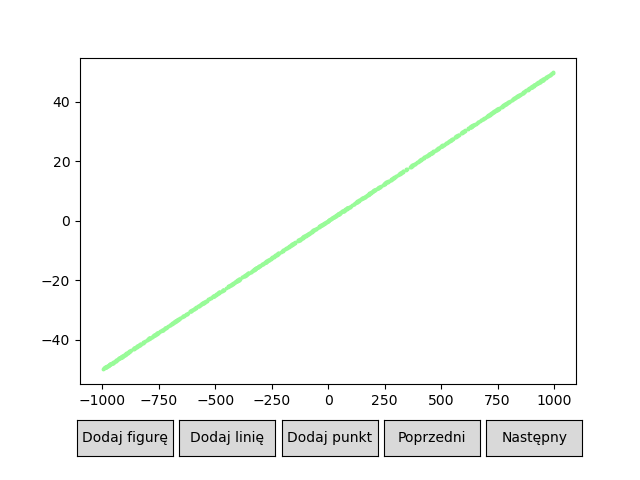

In [52]:
%matplotlib notebook
group_plot(set_d,det1, 10**-14, set_d = True)

right: 48
left : 48
coll : 904


<IPython.core.display.Javascript object>


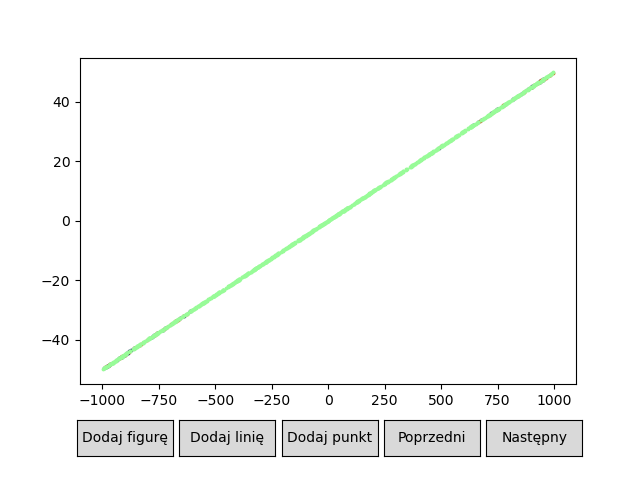

In [53]:
%matplotlib notebook
group_plot(set_d,det1_lib, 10**-14, set_d = True)

diff:  96


<IPython.core.display.Javascript object>


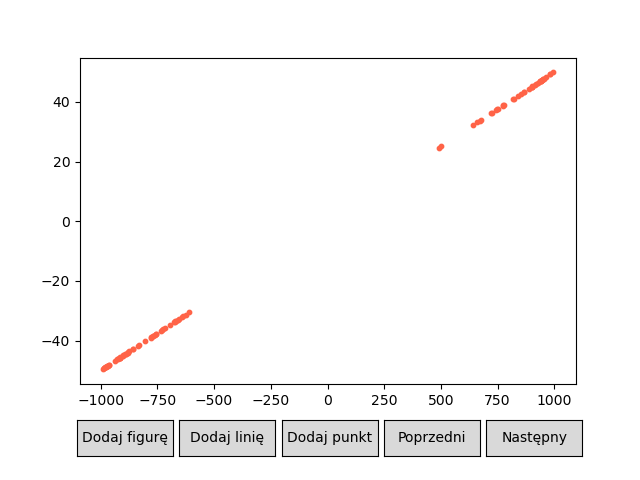

In [54]:
%matplotlib notebook
diff_plot(set_d,det1, det1_lib, 10**-14)

In [55]:
%matplotlib notebook
diff_plot(set_d,det1, det1_lib, 10**-11)

diff:  0


In [56]:
def compare_tolerance():
    for i, Set in enumerate([set_a, set_b, set_c, set_d]):
        Set_names = ["set_a", "set_b", "set_c", "set_d"]
        print("---", Set_names[i], "---\n")
        for e in [0, 10**-18, 10**-14, 10**-11, 10**-8]:
            print("TOLERANCE:",e, "\n")
            
            for idx, det in enumerate([det1, det2, det1_lib, det2_lib]):
                cw, ccw, coll = group(Set, det, e)
                det_names = ["det1", "det1_lib", "det2", "det2_lib"]
                print("*",det_names[idx], "*\n")
               
                print("GROUPS:")
                print("right:", len(cw))
                print("left :", len(ccw))
                print("coll :", len(coll))
                print()
                print()
                
                if idx == 1 or idx == 3 :
                    print("DIFFERENCES:")
                    if idx == 1:
                        print("det1, det1_lib:", len(compare(Set, det1, det1_lib, e)),"\n")
                        print()
                    else:
                        print("det2, det2_lib:", len(compare(Set, det2, det2_lib, e)),"\n")
                        print()
                        # wykres

    

In [57]:
compare_tolerance()

--- set_a ---

TOLERANCE: 0 

* det1 *

GROUPS:
right: 50215
left : 49785
coll : 0


* det1_lib *

GROUPS:
right: 50215
left : 49785
coll : 0


DIFFERENCES:
det1, det1_lib: 0 


* det2 *

GROUPS:
right: 50215
left : 49785
coll : 0


* det2_lib *

GROUPS:
right: 50215
left : 49785
coll : 0


DIFFERENCES:
det2, det2_lib: 0 


TOLERANCE: 1e-18 

* det1 *

GROUPS:
right: 50215
left : 49785
coll : 0


* det1_lib *

GROUPS:
right: 50215
left : 49785
coll : 0


DIFFERENCES:
det1, det1_lib: 0 


* det2 *

GROUPS:
right: 50215
left : 49785
coll : 0


* det2_lib *

GROUPS:
right: 50215
left : 49785
coll : 0


DIFFERENCES:
det2, det2_lib: 0 


TOLERANCE: 1e-14 

* det1 *

GROUPS:
right: 50215
left : 49785
coll : 0


* det1_lib *

GROUPS:
right: 50215
left : 49785
coll : 0


DIFFERENCES:
det1, det1_lib: 0 


* det2 *

GROUPS:
right: 50215
left : 49785
coll : 0


* det2_lib *

GROUPS:
right: 50215
left : 49785
coll : 0


DIFFERENCES:
det2, det2_lib: 0 


TOLERANCE: 1e-11 

* det1 *

GROUPS:
right: 